In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
import latent_plot as lp
from torch.autograd import Variable
from torch.optim import lr_scheduler
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from data_loader import FundusDataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
csv_path = '/home/vip/sayan-mandal/datasets/obj_criteria/20200619-objective.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

ResizeParam = 128
FD = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.RandomHorizontalFlip(p=0.5) ,transforms.ToTensor()]))
FD2 = FundusDataLoader(csv_path, img_path,transform=transforms.Compose([transforms.Resize(ResizeParam), transforms.ToTensor()]))

#random sampler
batch_size = 128
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(FD)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(FD, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(FD2, batch_size=batch_size, sampler=valid_sampler)


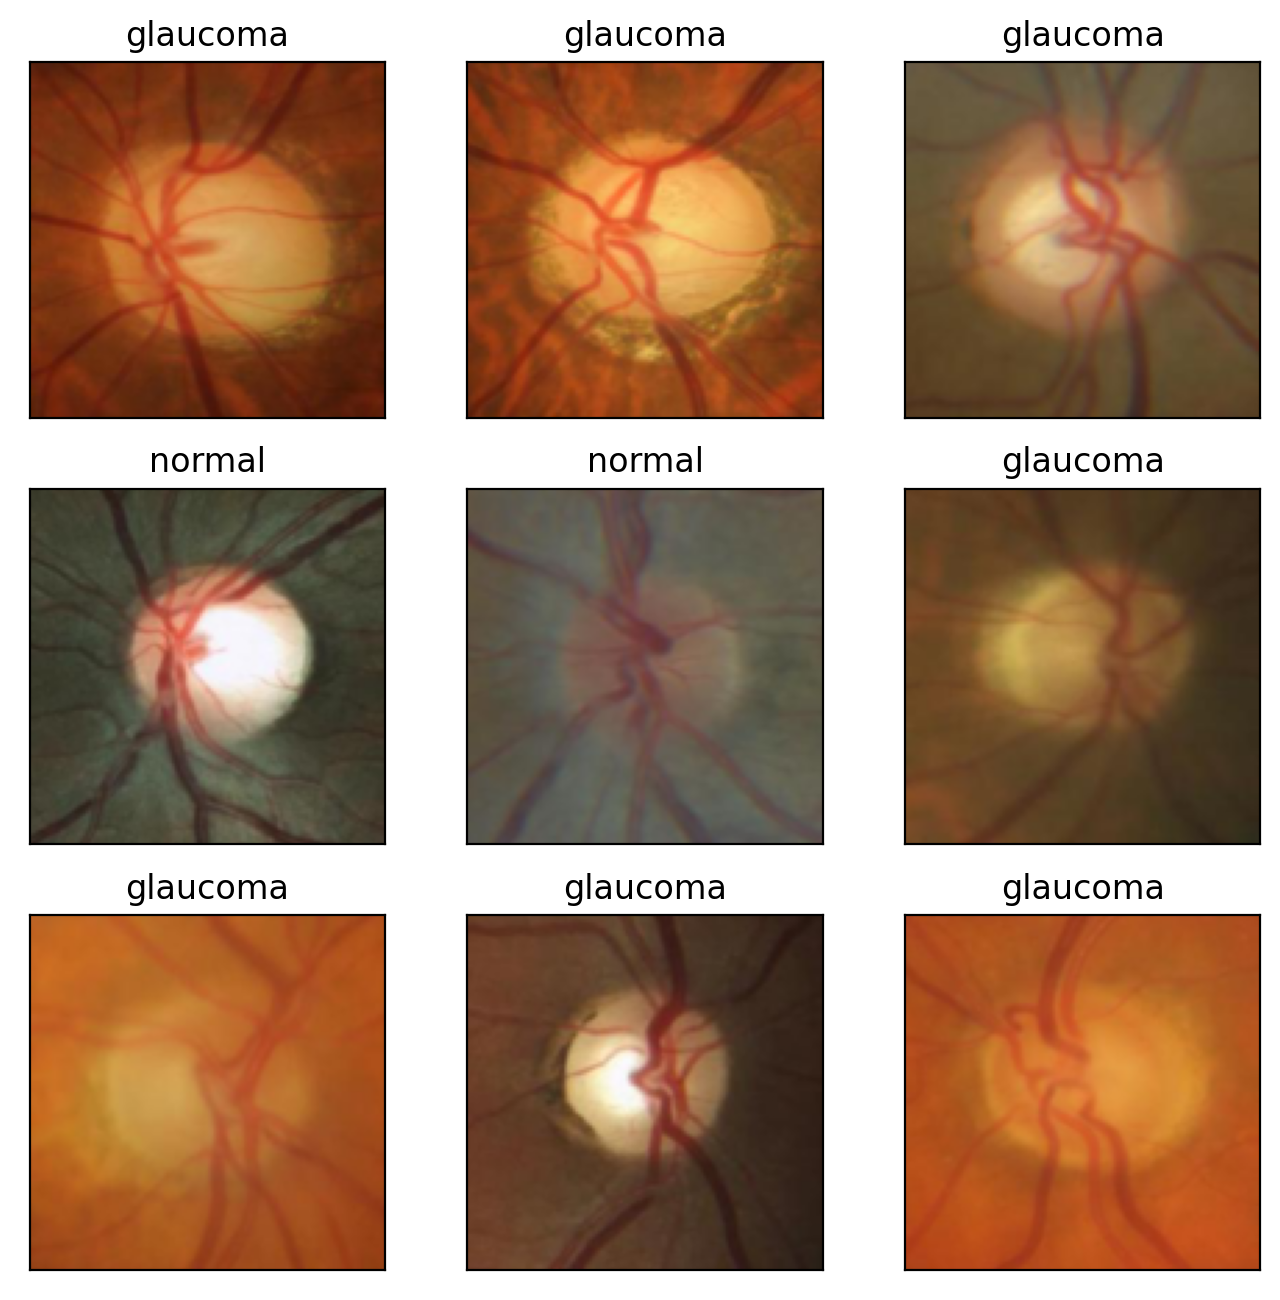

In [4]:
#Utility functions to un-normalize and display an image
def imshow(img):
    #img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['normal','glaucoma']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:
#kl divergence loss
#lossfunc = F.mse_loss(y,x)

def criterion(y, x, mu, logvar, beta):
    # recontruction loss
    recon = F.mse_loss(y,x, reduction = 'sum')
    #recon = F.binary_cross_entropy(y,x, reduction='mean')
    #reconfunc = nn.BCELoss()
    #reconfunc.size_average = False
    #recon = reconfunc(y,x)
    # kl divergence between Q(z|x) ~ N(mu, sigma) and P(z) ~ N(0, I)
    kl = -0.5*torch.sum(1+logvar-mu.pow(2) - logvar.exp())
    #kl/= y.shape[0]*y.shape[1]*y.shape[2]*y.shape[3]
    return (recon + beta * kl), recon, kl

In [6]:


class convVAE(nn.Module):
    def __init__(self, in_shape, n_latent):
        super(convVAE, self).__init__()
        self.in_shape = in_shape
        self.lin_shape = 16
        self.n_latent = n_latent
        c,h,w = in_shape
        self.z_dim = h//2**2 # receptive field downsampled 3 times
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 16, kernel_size=3, stride=1, padding=1, bias=False),  # 16, 128, 128
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1, bias=False),  # 32, 64, 64
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),  # 64, 64, 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, self.lin_shape, kernel_size=3, stride=2, padding=1, bias=False),  # 16, 32, 32
            nn.BatchNorm2d(self.lin_shape),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(self.lin_shape * (self.z_dim)**2, n_latent),
            nn.BatchNorm1d(n_latent),
            nn.ReLU(),
        )
        self.fc21 = nn.Sequential(
            nn.Linear(n_latent, n_latent),
        )
        self.fc22 = nn.Sequential(
            nn.Linear(n_latent, n_latent),
        )

        self.fc3 = nn.Sequential(
            nn.Linear(n_latent, n_latent),
            nn.BatchNorm1d(n_latent),
            nn.ReLU(),
            nn.Linear(n_latent, self.lin_shape * (self.z_dim)**2),
            nn.BatchNorm1d(self.lin_shape * (self.z_dim)**2),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.lin_shape, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias= False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1, bias= False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1, bias= False)
        )

    def sample_z(self, mean, logvar):
        stddev = logvar.mul(0.5).cuda()
        noise = Variable(torch.randn(*mean.size())).cuda()
        return (noise * stddev) + mean

    def bottleneck(self, h):
        h = self.fc1(h)
        mean, logvar = self.fc21(h), self.fc22(h)
        z = self.sample_z(mean, logvar)
        return z, mean, logvar

    def encode(self, x):
        x = self.encoder(x)
        z, mean, logvar = self.bottleneck(x)
        return z, mean, logvar

    def decode(self, z):
        out = self.fc3(z)
        out = out.view(out.shape[0], self.lin_shape, self.z_dim,self.z_dim)
        out = self.decoder(out)
        return out

    def forward(self, x):
        z,mean, logvar = self.encode(x)
        out = self.decode(z)
        return out, mean, logvar



model = convVAE((3,128,128),2048).cuda()
print(model)

convVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True,

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 80, gamma = 0.1)
epochs = 200
#beta_vals = np.linspace(0,1,20)
beta = 1
ep,lss,kll,bcel, vlss,vkll,vbcel = [],[],[],[],[],[],[]
best_loss = float('inf')
for e in range(epochs):
    model.train()
    tr_loss = tr_bce = tr_kld = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data).cuda()
        optimizer.zero_grad()
        y, mu, sig = model(data) # y = reconstructed image
        loss,bce,kld = criterion(y, data, mu, sig, beta)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        tr_bce += bce.item()
        tr_kld += kld.item()

    #validation
    model.eval()
    val_loss = val_bce = val_kld = 0
    with torch.no_grad():
        for data, _ in validation_loader:
            data = Variable(data).cuda()
            y, mu, sig = model(data)
            loss,bce,kld = criterion(y, data, mu, sig,beta)
            val_loss += loss.item()
            val_bce += bce.item()
            val_kld += kld.item()

    if tr_loss + val_loss < best_loss:
        best_loss = tr_loss + val_loss
        best_e = e
        best_model = copy.deepcopy(model)

    #scheduler.step()
        
    to_print = "Epoch[{}/{}], Train Loss: {:.4f} {:.4f} {:.4f} | Valid Loss: {:.4f} {:.4f} {:.4f}".format(e+1, 
                                epochs, tr_loss/(dataset_size*0.8), tr_bce/(dataset_size*0.8), tr_kld/(dataset_size*0.8), val_loss/(dataset_size*0.2), val_bce/(dataset_size*0.2), val_kld/(dataset_size*0.2))
    print(to_print)
    ep += [e]
    lss += [tr_loss/(dataset_size*0.8)]
    kll += [tr_kld/(dataset_size*0.8)]
    bcel += [tr_bce/(dataset_size*0.8)]
    vlss += [val_loss/(dataset_size*0.2)]
    vkll += [val_kld/(dataset_size*0.2)]
    vbcel += [val_bce/(dataset_size*0.2)]

Epoch[1/200], Train Loss: 6591.9521 6096.1363 495.8158 | Valid Loss: 1351.0957 1239.3337 111.7620
Epoch[2/200], Train Loss: 1173.3579 988.0431 185.3147 | Valid Loss: 1055.6192 793.9398 261.6794
Epoch[3/200], Train Loss: 1068.1513 789.4008 278.7505 | Valid Loss: 742.2817 633.6388 108.6429
Epoch[4/200], Train Loss: 682.0190 595.0184 87.0006 | Valid Loss: 842.7997 687.7859 155.0138
Epoch[5/200], Train Loss: 561.7233 493.8085 67.9148 | Valid Loss: 531.8275 481.1180 50.7095
Epoch[6/200], Train Loss: 532.7944 444.5207 88.2738 | Valid Loss: 461.2395 400.7903 60.4492
Epoch[7/200], Train Loss: 432.6273 380.0605 52.5668 | Valid Loss: 373.1469 339.6730 33.4740
Epoch[8/200], Train Loss: 355.8063 314.6603 41.1460 | Valid Loss: 842.8922 754.5100 88.3821
Epoch[9/200], Train Loss: 366.5309 293.4810 73.0498 | Valid Loss: 330.5022 288.3261 42.1760
Epoch[10/200], Train Loss: 300.4779 256.2445 44.2334 | Valid Loss: 289.0133 248.4716 40.5417
Epoch[11/200], Train Loss: 331.0675 255.3104 75.7571 | Valid Loss

In [14]:
torch.save(best_model.state_dict(), 'convvae_inp128_nl2048_b1.torch')

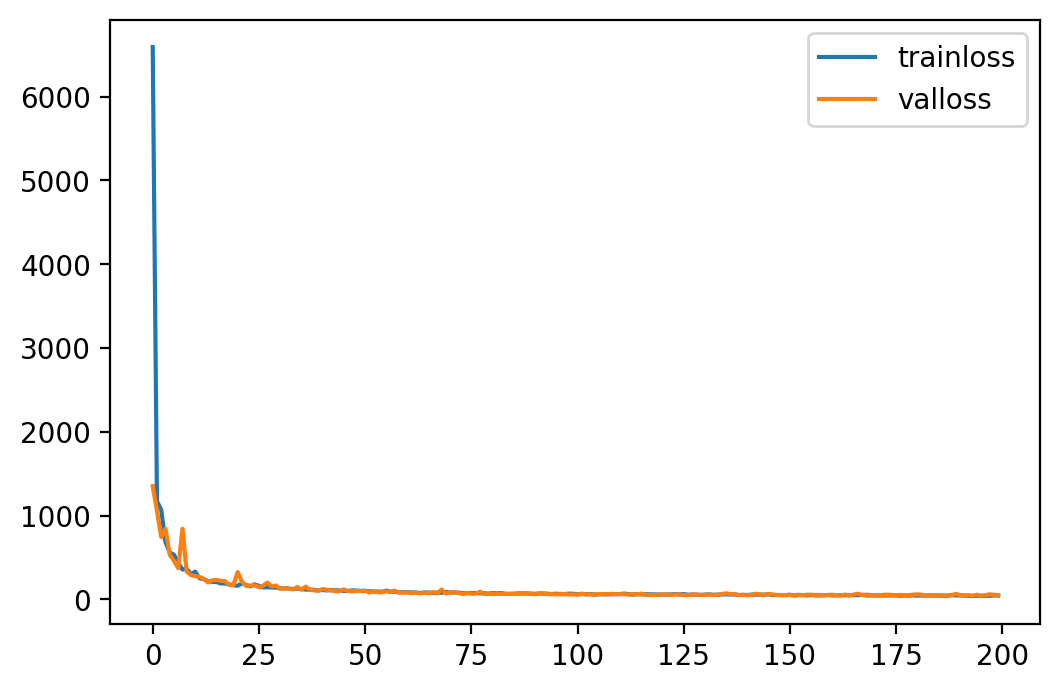

In [11]:
plt.plot(ep, lss, label = 'trainloss')
plt.plot(ep,vlss, label = 'valloss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


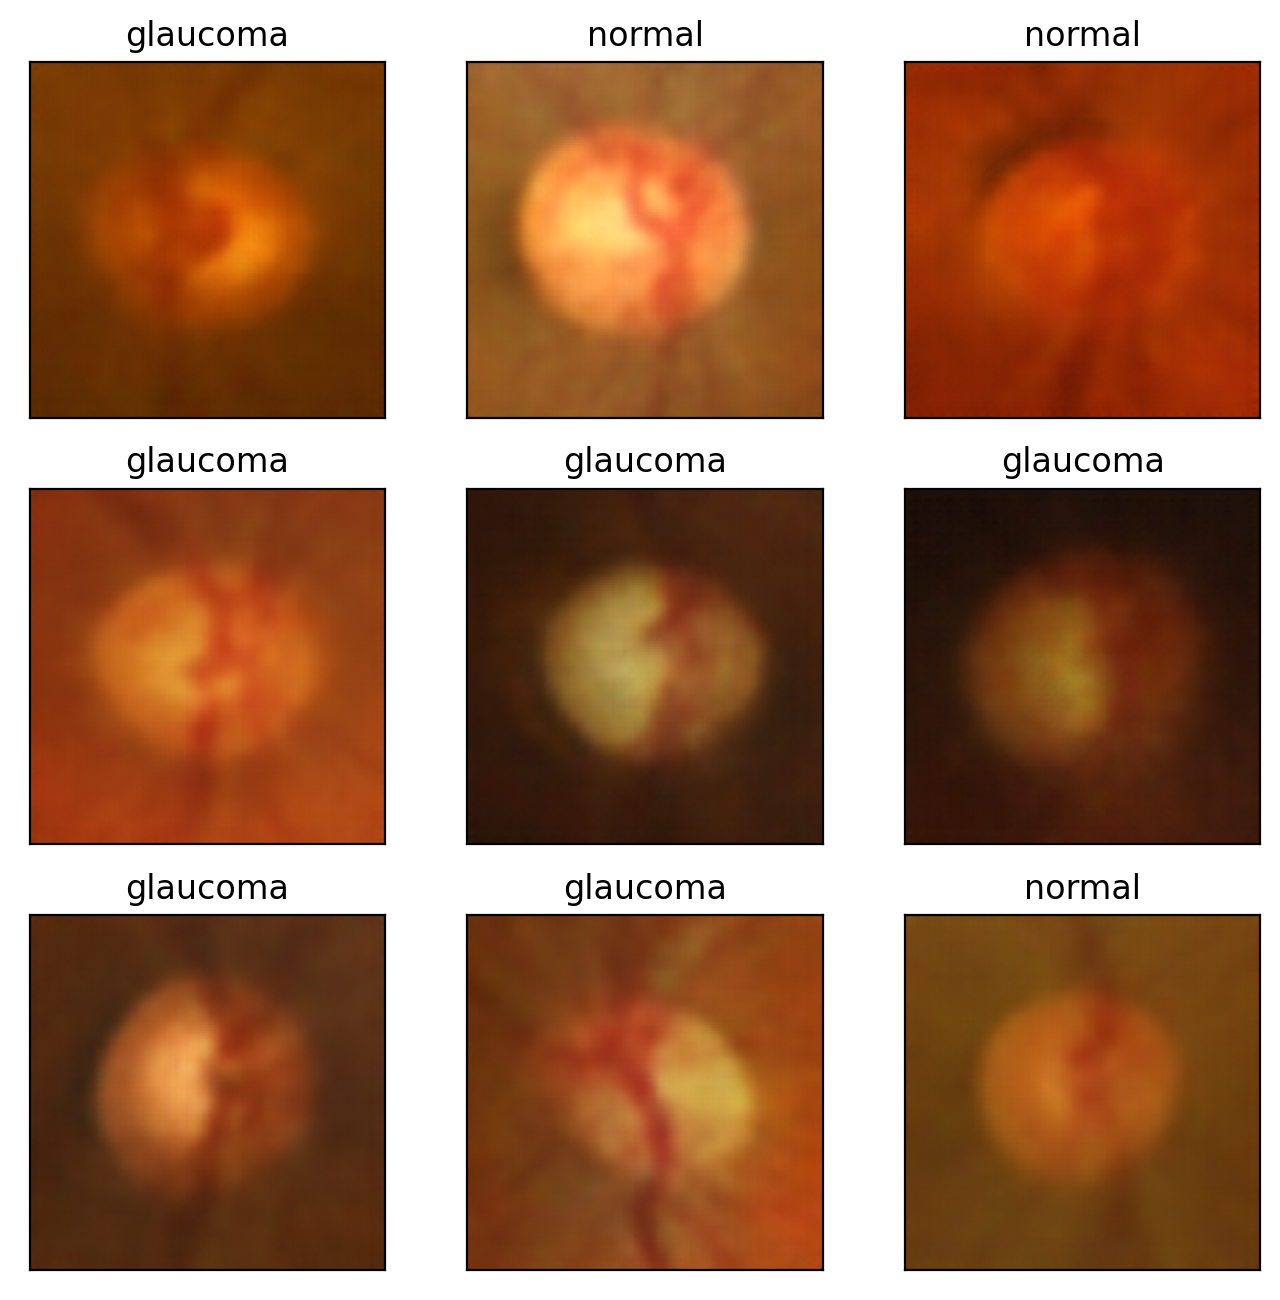

In [8]:
#Obtain one batch of training images
dataiter = iter(train_loader)
data, labels = dataiter.next()
best_model.eval()
images,_,_ = best_model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


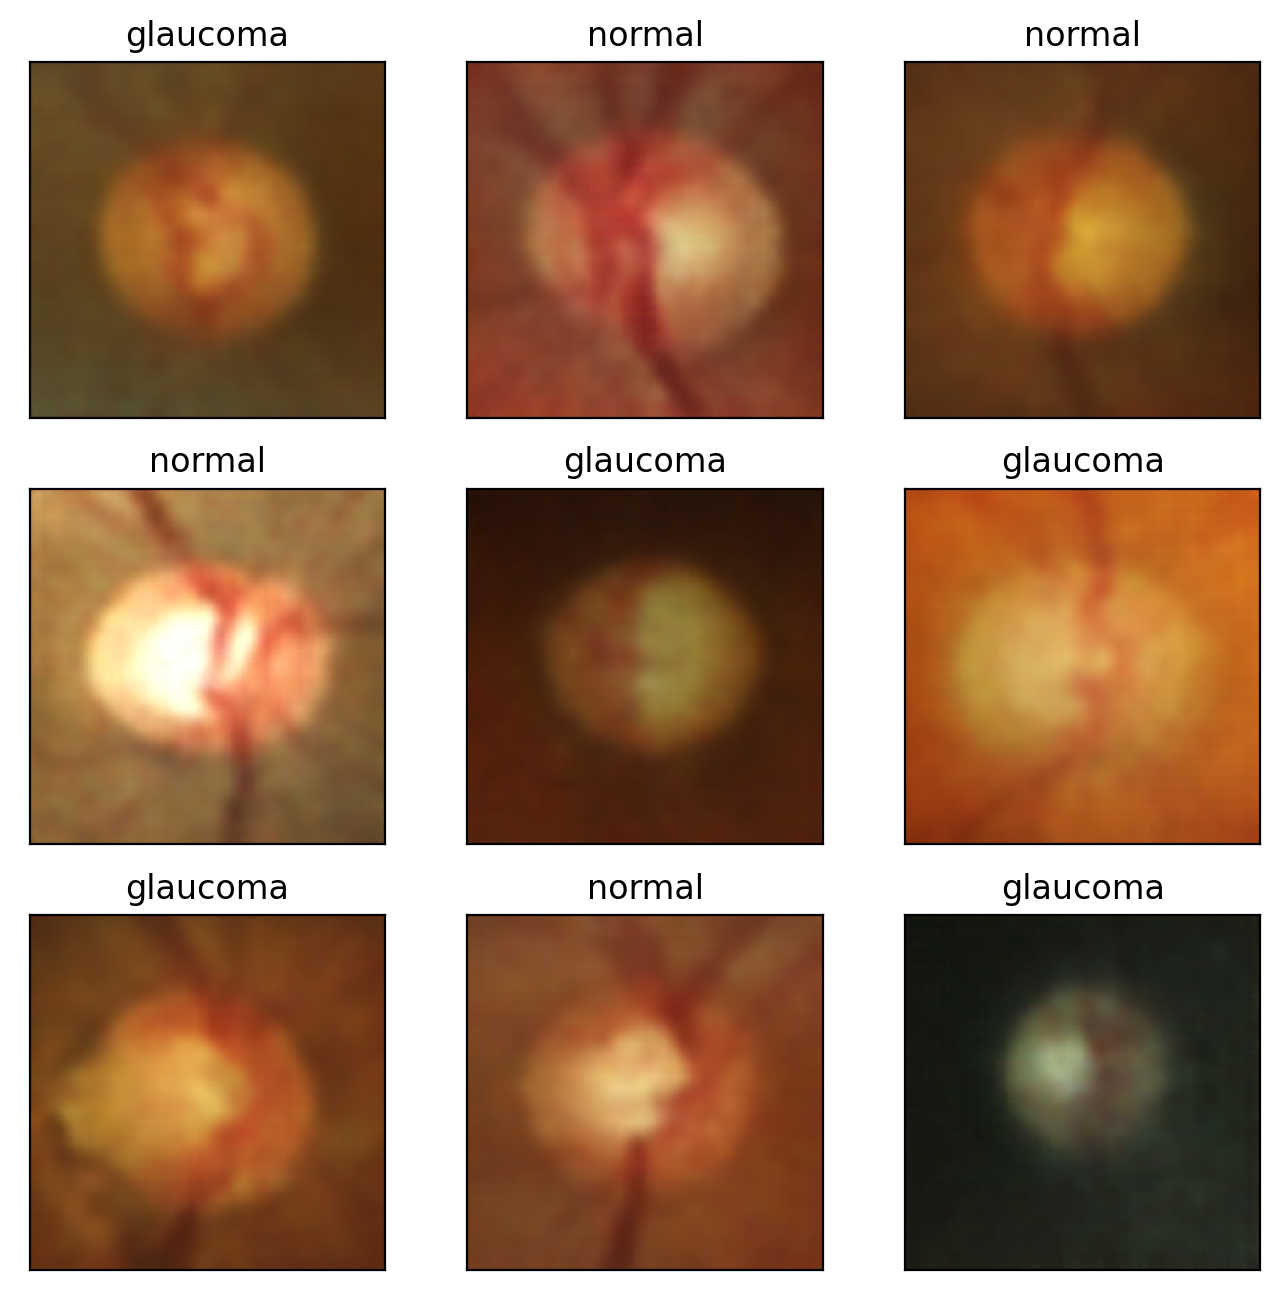

In [9]:
#Obtain one batch of training images
dataiter = iter(train_loader)
data, labels = dataiter.next()
model.eval()
images,_,_ = model(Variable(data).cuda())
images = images.detach().cpu().numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
from sklearn.manifold import TSNE

n_comp = 2
perplexity = 30

In [13]:

for i, (data,label) in enumerate(train_loader):
    y, _,_ =  best_model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

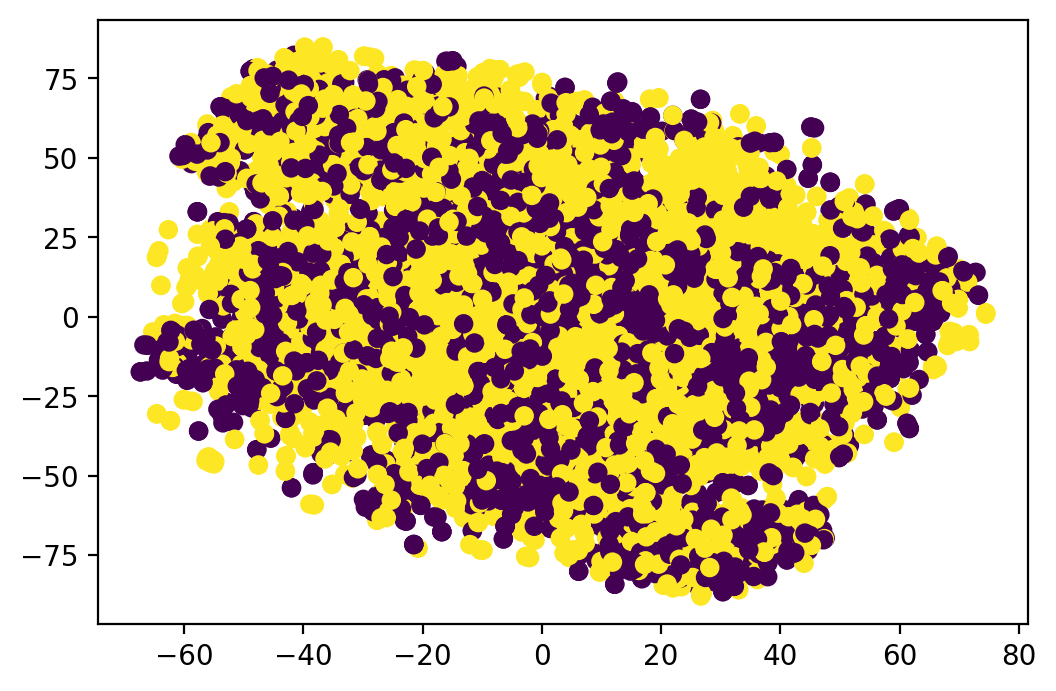

In [14]:
y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)
#labels = ['normal','glaucoma']
plt.scatter(y_embed[:,0],y_embed[:,1],c=lbl)
plt.show()

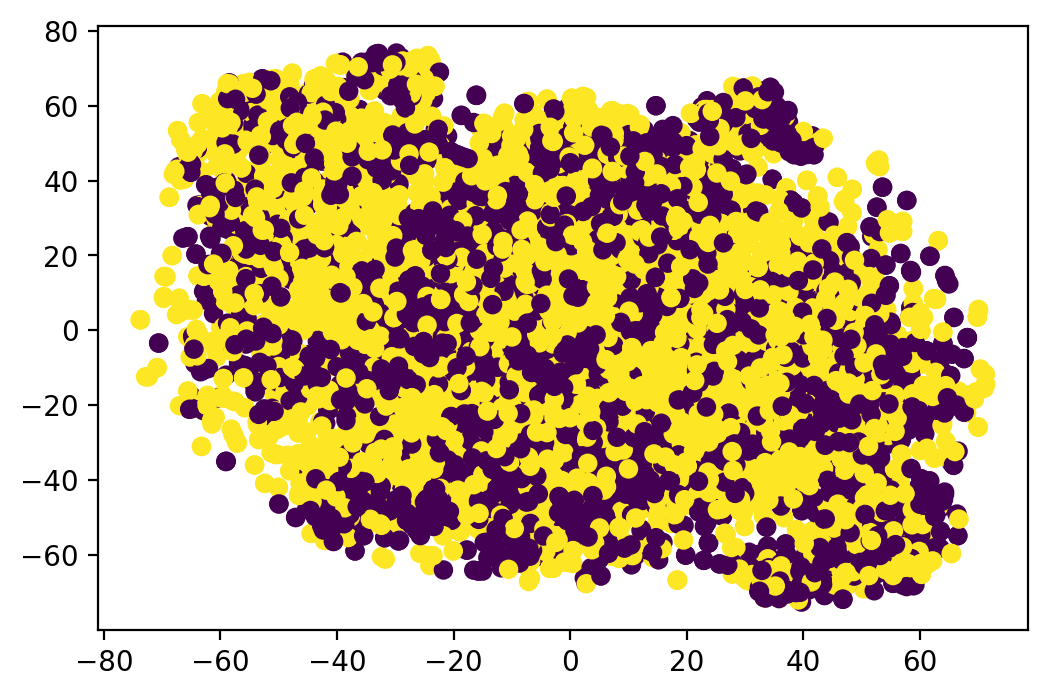

In [15]:

for i, (data,label) in enumerate(train_loader):
    y, _,_ =  model.encode(Variable(data).cuda())
    y = y.cpu().detach().numpy()
    if i == 0:
        yd = y
        lbl = label.numpy()
    else:
        yd = np.append(yd,y,axis=0)
        lbl = np.append(lbl,label.numpy(), axis=0)

y_embed = TSNE(n_components=n_comp, perplexity=perplexity).fit_transform(yd)
#labels = ['normal','glaucoma']
plt.scatter(y_embed[:,0],y_embed[:,1],c=lbl)
plt.show()

In [11]:
images.max()

1.0